In [ ]:
import os 
import xarray as xr
import pandas as pd
import numpy as np
import openpyxl
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [23]:
# Paths 
path_sentinel2_data = "/home/khanalp/data/sentinel/l2a"
path_sentinel2_metadata = "/home/khanalp/data/sentinel/l2a/metadata"
path_model_reflectance = "/home/khanalp/STEMMUS_SCOPE_model/STEMMUS_SCOPE_old/STEMMUS_SCOPE/ICOS_sites/BE-Lon/output/BE-Lon_2024-04-15-1359/reflectance.csv"
path_spectral_model = "/home/khanalp/code/PhD/daytoday/spectral_STEMMUS_SCOPE.mat"
path_model_output =  "/home/khanalp/data/processed/output_pystemmus"
path_sentinel2_spectral_response = "/home/khanalp/data/sentinel/S2-SRF_COPE-GSEG-EOPG-TN-15-0007_3.2.xlsx"

In [ ]:
# Stations
station = "BE-Lon"

In [4]:
# Find corresponding files according to the station
sentinel2_file_station = [f for f in os.listdir(path_sentinel2_data) if station in f]
sentinel2_metafile_station = [f for f in os.listdir(path_sentinel2_metadata) if station in f]
model_output_station = [f for f in os.listdir(path_model_output) if station in f]

In [5]:
# Read them
ds_modeloutput = xr.open_dataset(os.path.join(path_model_output, model_output_station[0]))
ds_sentinel2 = xr.open_dataset(os.path.join(path_sentinel2_data, sentinel2_file_station[0]))
df_sentinel2 = pd.read_csv(os.path.join(path_sentinel2_metadata, sentinel2_metafile_station[0]))
df_model_reflectance = pd.read_csv(path_model_reflectance, skiprows=2)


In [6]:
# Change to pd datetime
df_sentinel2['datetime'] = pd.to_datetime(df_sentinel2['datetime']) # It is in UTC time

In [7]:
# Remove dupliocates
df_sentinel2 = df_sentinel2.drop_duplicates(subset='datetime')
df_sentinel2['datetime'] = df_sentinel2['datetime'].dt.tz_convert(None)

In [8]:
df_sentinel2

,station,datetime,platform
0,BE-Lon,2015-07-06 10:50:16.027,A
2,BE-Lon,2015-07-16 10:50:26.027,A
4,BE-Lon,2015-07-26 10:50:26.027,A
6,BE-Lon,2015-08-02 10:40:26.027,A
8,BE-Lon,2015-08-05 10:50:26.027,A
...,...,...,...
1875,BE-Lon,2024-03-20 10:47:41.024,A
1876,BE-Lon,2024-03-22 10:36:39.024,B
1877,BE-Lon,2024-03-25 10:46:39.024,B
1879,BE-Lon,2024-03-27 10:36:41.024,A


In [9]:
# Convert xarray time coordinate to pandas datetime
ds_times = pd.to_datetime(ds_sentinel2.t.values)

# Get exact times and platforms for each date (The ds has datetime but all time are 00:00, so i add the exact satellite overpass time in corresponding location.)
exact_times = []
platforms = []

for date in ds_times:
    matches = df_sentinel2[df_sentinel2['datetime'].dt.date == date.date()]
    if not matches.empty:
        exact_times.append(matches['datetime'].iloc[0])
        platforms.append(matches['platform'].iloc[0])
    else:
        exact_times.append(pd.NaT)
        platforms.append(np.nan)


In [10]:
#Convert to numpy arrays
exact_times_np = pd.to_datetime(exact_times).to_numpy()
platforms_np = np.array(platforms, dtype='object')  # use object dtype for strings

#  Assign to ds_sentinel2
ds_sentinel2['overpass_time'] = (('t',), exact_times_np)
ds_sentinel2['platform'] = (('t',), platforms_np)

1. now comparing model, i need to find time in model corresponding to satellite overpass time. 
2. Then, i need to use spectral response function to change the spectra of Sentinel 2 to the model spectra wavelength. 
3. The make comparison.

In [11]:
# Load the .mat file
spectral = loadmat(path_spectral_model)
wlS = np.array(spectral['wlS']).flatten()
 # Convert to micrometers
wv_wlS = [f"{int(w)}_nm" for w in wlS]  # Convert to strings with '_nm' suffix
df_model_reflectance.columns = wv_wlS

In [ ]:
df_model_reflectance['datetime'] = pd.to_datetime(ds_modeloutput.time[1:])
df_model_reflectance.set_index('datetime', inplace=True)


In [14]:
overpass_time_within_range = ds_sentinel2['overpass_time'] <= df_model_reflectance.index.max()
ds_sentinel2 = ds_sentinel2.sel(t=overpass_time_within_range)


In [ ]:
closest_times = df_model_reflectance.index.get_indexer(ds_sentinel2['overpass_time'], method='nearest')


In [16]:
df_model_reflectance_selected = df_model_reflectance.iloc[closest_times]

In [18]:
df_model_reflectance_selected = df_model_reflectance_selected.dropna(axis=1, how='all')

In [28]:
# Read the Sentinel-2 spectral response file
df_spectral_response_sentinel_A = pd.read_excel(path_sentinel2_spectral_response, sheet_name="Spectral Responses (S2A)")
df_spectral_response_sentinel_B = pd.read_excel(path_sentinel2_spectral_response, sheet_name="Spectral Responses (S2B)") # Read all sheets

/home/khanalp/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/khanalp/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [73]:
# Initialize the DataFrame with SR_WL column
df_result = pd.DataFrame({'SR_WL': df_spectral_response_sentinel_A['SR_WL']})

In [74]:
spectral_response_columns = [col for col in df_spectral_response_sentinel_A.columns if col.startswith("S2A_SR_AV_")]

In [102]:
ds_sentinel2_first_time_step = ds_sentinel2.isel(t=0)

In [ ]:
# Iterate over the variables in ds_sentinel2_first_time_step
for var in ds_sentinel2_first_time_step.data_vars:
    if var.startswith("B0"):
        var_stripped = f"B{int(var[1:]):d}"  # Convert to 'B1', 'B2', etc.
    else:
        var_stripped = var  # Keep it as is
    if var_stripped in [col.split("_")[-1] for col in spectral_response_columns]:
        spectral_response_column = f"S2A_SR_AV_{var_stripped}"
        spectral_response_values = df_spectral_response_sentinel_A[spectral_response_column].values
        df_result[var] = spectral_response_values * ds_sentinel2_first_time_step[var].values[0]
        

In [115]:
df_result = df_result[(df_result['SR_WL'] >= 400) & (df_result['SR_WL'] <= 1000)]

In [120]:
df_result.iloc[:, 1:] = df_result.iloc[:, 1:] * 0.0001

/home/khanalp/tmp/ipykernel_2853533/4189218354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result.iloc[:, 1:] = df_result.iloc[:, 1:] * 0.0001


In [ ]:
# Check columns where all values are zero
all_zero_columns = df_result.columns[(df_result == 0).all()]
print("Columns that always have zero values:", list(all_zero_columns))


Columns that always have zero values: ['B11', 'B12']


In [ ]:
# Plot the first index in df_model_reflectance_selected
first_index = df_model_reflectance_selected.iloc[0]

In [241]:
# Filter columns between 400 nm and 10000 nm (inclusive)
filtered_columns = [col for col in df_model_reflectance.columns if 400 <= float(col.replace('_nm', '')) <= 1000]

# Create a new DataFrame with the filtered columns
df_filtered_reflectance = df_model_reflectance[filtered_columns]

In [242]:
df_filtered_reflectance

,400_nm,401_nm,402_nm,403_nm,404_nm,405_nm,406_nm,407_nm,408_nm,409_nm,...,991_nm,992_nm,993_nm,994_nm,995_nm,996_nm,997_nm,998_nm,999_nm,1000_nm
datetime,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/khanalp/tmp/ipykernel_2853533/53557533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result[column] = df_result[column].where(df_result[column] != 0, np.nan)


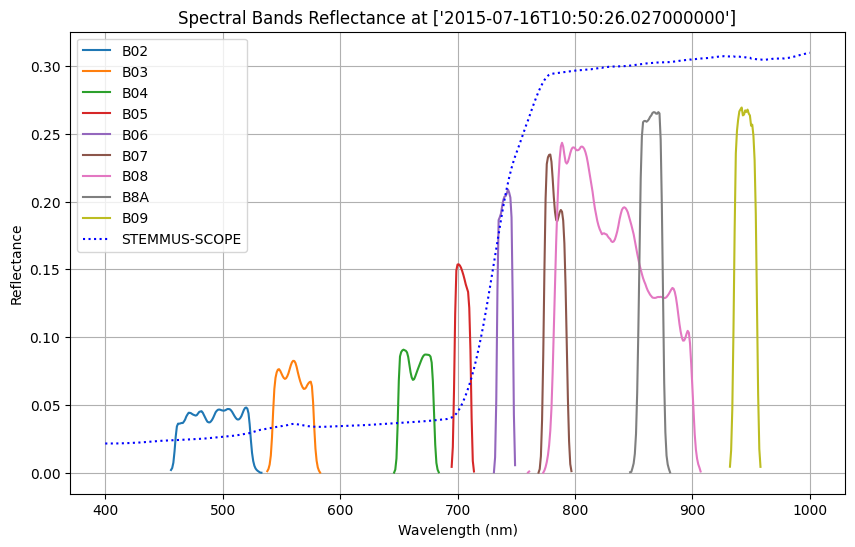

In [155]:

# Filter out columns where all values are zero
columns_to_plot = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09']

# For each column, mask zero values
for column in columns_to_plot:
    df_result[column] = df_result[column].where(df_result[column] != 0, np.nan)

    
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    plt.plot(df_result['SR_WL'], df_result[column], label=column)
    
# Plot the first_index values
plt.plot(df_result['SR_WL'], first_index.values, label='STEMMUS-SCOPE', linestyle='dotted', color='blue')

# Add labels, legend, and title
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title(f'Spectral Bands Reflectance at {ds_sentinel2_first_time_step.overpass_time.values.flatten()}')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Filter the range 400_nm to 500_nm
filtered_data = first_index.loc['400_nm':'500_nm']
filtered_data.index = filtered_data.index.to_series().str.extract(r'(\d+)').astype(int).iloc[:, 0]

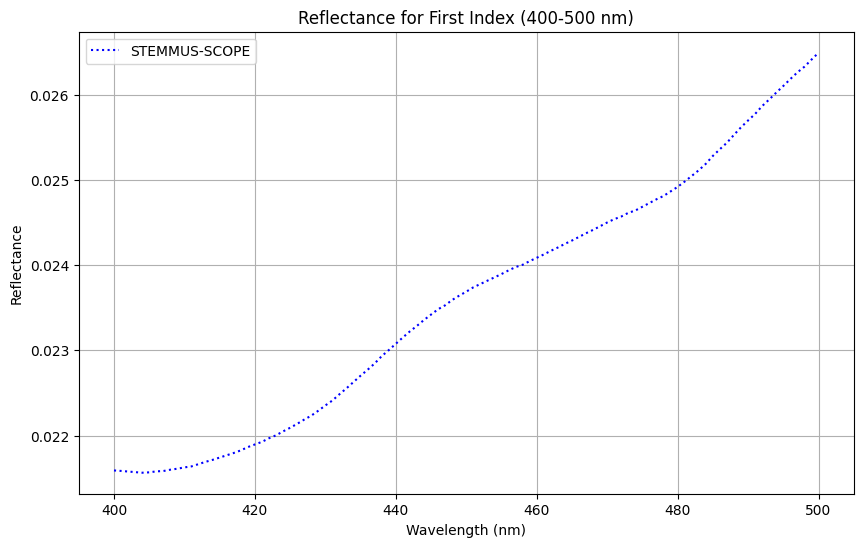

In [150]:

# Plot the filtered data
plt.figure(figsize=(10, 6))

plt.plot(filtered_data.index, filtered_data.values, label='STEMMUS-SCOPE', linestyle='dotted', color='blue')

# Add labels, title, and legend
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Reflectance for First Index (400-500 nm)')
plt.legend()
plt.grid()
plt.show()

Time series of band

In [164]:
# Initialize the DataFrame with SR_WL column
df_result_timeseries_model = pd.DataFrame({'datetime': df_model_reflectance_selected.index})

In [168]:
df_spectral_response_sentinel_A_selected = df_spectral_response_sentinel_A[(df_spectral_response_sentinel_A['SR_WL'] >= 400) & (df_spectral_response_sentinel_A['SR_WL'] <= 1000)]

In [182]:
df_spectral_response_sentinel_A_selected.columns

Index(['SR_WL', 'S2A_SR_AV_B1', 'S2A_SR_AV_B2', 'S2A_SR_AV_B3', 'S2A_SR_AV_B4',
       'S2A_SR_AV_B5', 'S2A_SR_AV_B6', 'S2A_SR_AV_B7', 'S2A_SR_AV_B8',
       'S2A_SR_AV_B8A', 'S2A_SR_AV_B9', 'S2A_SR_AV_B10', 'S2A_SR_AV_B11',
       'S2A_SR_AV_B12'],
      dtype='object')

array([0.02159033, 0.0215847 , 0.02157765, 0.02157064, 0.02156362,
       0.02156798, 0.02157955, 0.02158353, 0.02159918, 0.02161081,
       0.02162624, 0.02163789, 0.02166463, 0.02169167, 0.02171478,
       0.02174165, 0.0217685 , 0.02179546, 0.02182609, 0.02186469,
       0.02189535, 0.02192597, 0.02196833, 0.02200286, 0.02204897,
       0.02209134, 0.02213743, 0.02218742, 0.02223364, 0.02229151,
       0.02235334, 0.02241145, 0.0224849 , 0.02255477, 0.02262866,
       0.02270257, 0.02277257, 0.02284644, 0.02293225, 0.02300291,
       0.0230773 , 0.02315165, 0.0232229 , 0.02328767, 0.02335678,
       0.02341991, 0.02348273, 0.02352889, 0.02359148, 0.02364218,
       0.02368896, 0.02373975, 0.02377868, 0.02381777, 0.02385674,
       0.02389577, 0.02393858, 0.02397756, 0.02400459, 0.02404739,
       0.02408647, 0.02412548, 0.0241682 , 0.02420727, 0.02425018,
       0.02428899, 0.02433165, 0.02437475, 0.02441404, 0.02445728,
       0.02450085, 0.02453992, 0.02457082, 0.02461413, 0.02464

In [183]:
df_model_reflectance_selected

,400_nm,401_nm,402_nm,403_nm,404_nm,405_nm,406_nm,407_nm,408_nm,409_nm,...,991_nm,992_nm,993_nm,994_nm,995_nm,996_nm,997_nm,998_nm,999_nm,1000_nm
datetime,,,,,,,,,,,,,,,,,,,,,
2015-07-16 11:00:00,0.021590,0.021585,0.021578,0.021571,0.021564,0.021568,0.021580,0.021584,0.021599,0.021611,...,0.307891,0.308159,0.308320,0.308542,0.308793,0.309007,0.309180,0.309402,0.309619,0.309787
2015-10-01 10:30:00,0.024901,0.024890,0.024876,0.024862,0.024848,0.024853,0.024873,0.024877,0.024900,0.024920,...,0.301717,0.301996,0.302176,0.302400,0.302665,0.302885,0.303056,0.303282,0.303505,0.303673
2015-12-03 11:00:00,0.057843,0.057832,0.057818,0.057803,0.057789,0.057852,0.057992,0.058055,0.058195,0.058334,...,0.295111,0.295476,0.295744,0.296021,0.296383,0.296659,0.296848,0.297125,0.297402,0.297590
2016-06-10 11:00:00,0.020593,0.020586,0.020579,0.020571,0.020563,0.020564,0.020571,0.020572,0.020583,0.020590,...,0.310204,0.310465,0.310619,0.310837,0.311079,0.311289,0.311462,0.311680,0.311893,0.312060
2016-07-10 11:00:00,0.019686,0.019678,0.019669,0.019660,0.019650,0.019649,0.019651,0.019649,0.019655,0.019657,...,0.311989,0.312244,0.312389,0.312603,0.312838,0.313044,0.313215,0.313430,0.313638,0.313805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-22 11:00:00,0.031616,0.031609,0.031601,0.031592,0.031584,0.031606,0.031655,0.031677,0.031730,0.031779,...,0.297248,0.297556,0.297765,0.298007,0.298306,0.298545,0.298721,0.298965,0.299205,0.299380
2020-10-09 10:30:00,0.028988,0.028976,0.028961,0.028947,0.028932,0.028943,0.028978,0.028989,0.029027,0.029061,...,0.298808,0.299102,0.299299,0.299530,0.299812,0.300042,0.300215,0.300449,0.300681,0.300852
2020-10-19 10:30:00,0.030251,0.030237,0.030220,0.030203,0.030185,0.030196,0.030233,0.030244,0.030284,0.030321,...,0.298455,0.298750,0.298951,0.299182,0.299466,0.299698,0.299870,0.300105,0.300338,0.300510


In [ ]:
def apply_srf_to_reflectance(
    df_reflectance: pd.DataFrame,
    df_srf: pd.DataFrame
) -> pd.DataFrame:
    """
    Applies spectral response functions to reflectance data to simulate sensor band values.

    Parameters:
    - df_reflectance (pd.DataFrame): DataFrame with datetime index and wavelength columns (e.g. '400_nm', ..., '1000_nm')
    - df_srf (pd.DataFrame): DataFrame with 'SR_WL' and SRF columns for each band.

    Returns:
    - pd.DataFrame: DataFrame with datetime index and simulated band values.
    """
    # Extract wavelengths from df_reflectance columns
    reflectance_wavelengths = np.array([int(col.replace('_nm', '')) for col in df_reflectance.columns])
    srf_wavelengths = df_srf['SR_WL'].values

    # Ensure reflectance and SRF wavelengths match exactly
    if not np.array_equal(reflectance_wavelengths, srf_wavelengths):
        raise ValueError("Wavelengths in reflectance data and SRF do not match.")

    # Convert reflectance DataFrame to NumPy array for performance
    reflectance_array = df_reflectance.values

    # Compute band values
    band_values = {}
    for band in df_srf.columns:
        if band == 'SR_WL':
            continue
        srf = df_srf[band].values
        srf_sum = np.sum(srf)
        if srf_sum == 0:
            band_values[band] = np.nan
            continue
        band_values[band] = (reflectance_array * srf).sum(axis=1) / srf_sum

    # Create result DataFrame
    df_band_values = pd.DataFrame(band_values, index=df_reflectance.index)
    return df_band_values


In [205]:
df_band_values = apply_srf_to_reflectance(df_model_reflectance_selected, df_spectral_response_sentinel_A_selected)
print(df_band_values.head())


                     S2A_SR_AV_B1  S2A_SR_AV_B2  S2A_SR_AV_B3  S2A_SR_AV_B4  \
datetime                                                                      
2015-07-16 11:00:00      0.023233      0.026176      0.034819      0.037602   
2015-10-01 10:30:00      0.027321      0.031440      0.042555      0.047084   
2015-12-03 11:00:00      0.069025      0.084969      0.113809      0.149644   
2016-06-10 11:00:00      0.021900      0.024445      0.032615      0.033837   
2016-07-10 11:00:00      0.020679      0.022762      0.030078      0.030341   

                     S2A_SR_AV_B5  S2A_SR_AV_B6  S2A_SR_AV_B7  S2A_SR_AV_B8  \
datetime                                                                      
2015-07-16 11:00:00      0.052558      0.201919      0.293857      0.299238   
2015-10-01 10:30:00      0.063482      0.203881      0.281995      0.288450   
2015-12-03 11:00:00      0.168189      0.222584      0.251881      0.262985   
2016-06-10 11:00:00      0.048396      0.201514    

In [243]:
df_band_values_complete = apply_srf_to_reflectance(df_filtered_reflectance, df_spectral_response_sentinel_A_selected)

In [232]:
band_map = {
    'B02': 'S2A_SR_AV_B2',
    'B03': 'S2A_SR_AV_B3',
    'B04': 'S2A_SR_AV_B4',
    'B05': 'S2A_SR_AV_B5',
    'B06': 'S2A_SR_AV_B6',
    'B07': 'S2A_SR_AV_B7',
    'B08': 'S2A_SR_AV_B8',
    'B8A': 'S2A_SR_AV_B8A',
    'B09': 'S2A_SR_AV_B9',
   
}


In [ ]:

def plot_band_comparisons(ds_sentinel2: xr.Dataset, df_band_values: pd.DataFrame, band_map: dict, feature_idx: int = 0):
    """
    Plot Sentinel-2 data vs modeled band values for each band.
    
    Parameters:
    - ds_sentinel2 (xr.Dataset): Sentinel-2 dataset with bands as variables.
    - df_band_values (pd.DataFrame): DataFrame with datetime index and modeled band values.
    - band_map (dict): Mapping from Sentinel-2 band names to modeled band names.
    - feature_idx (int): Index of the feature to plot from Sentinel-2 data.
    """
    overpass_times = pd.to_datetime(ds_sentinel2['overpass_time'].values)

    for s2_band, modeled_band in band_map.items():
        if s2_band not in ds_sentinel2 or modeled_band not in df_band_values.columns:
            continue

        s2_values = ds_sentinel2[s2_band].sel(feature=feature_idx).values * 0.0001
        modeled_values = df_band_values[modeled_band].values

        plt.figure(figsize=(10, 4))
        plt.scatter(overpass_times, s2_values, label='Sentinel-2', marker='o')
        plt.scatter(overpass_times, modeled_values, label='Model Reflectance', marker='x')
        plt.title(f'Band {s2_band} vs {modeled_band}')
        plt.xlabel('Time')
        plt.ylabel('Reflectance')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


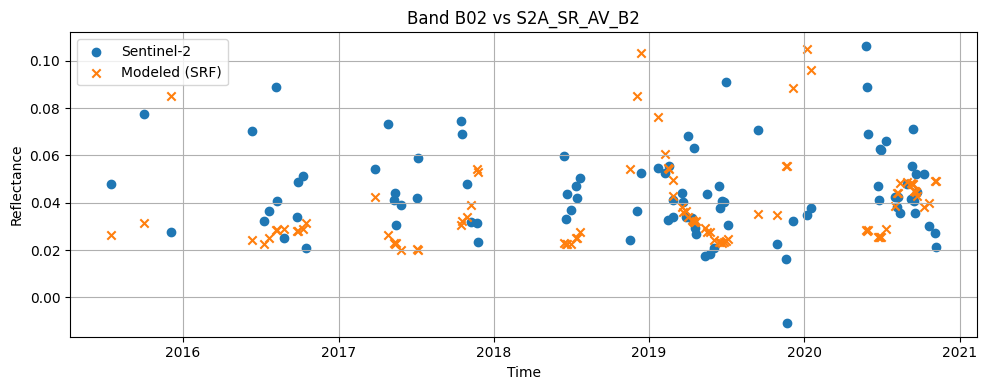

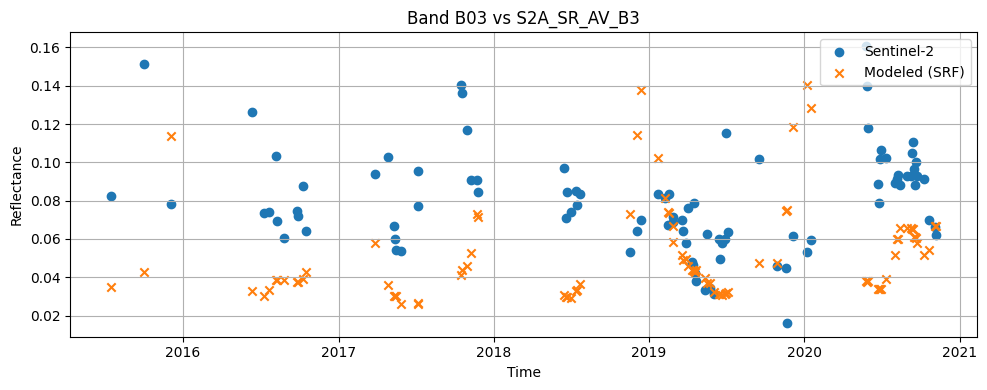

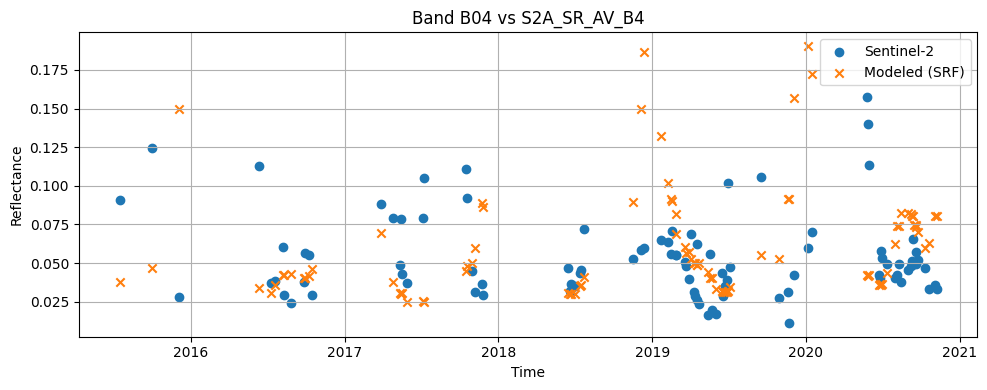

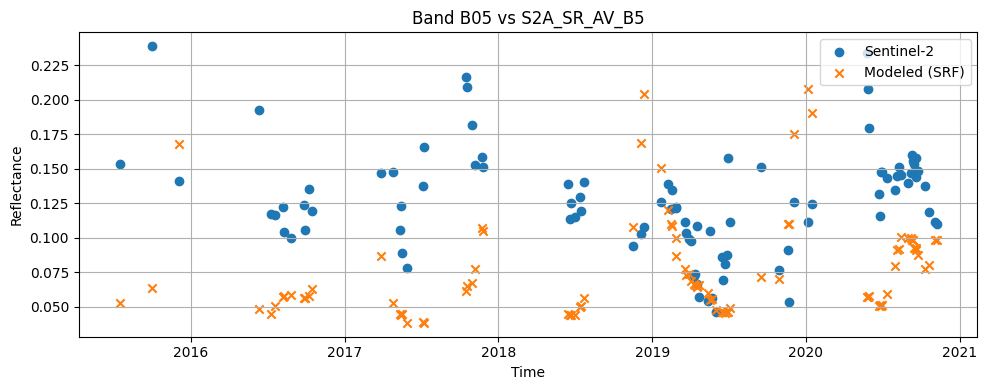

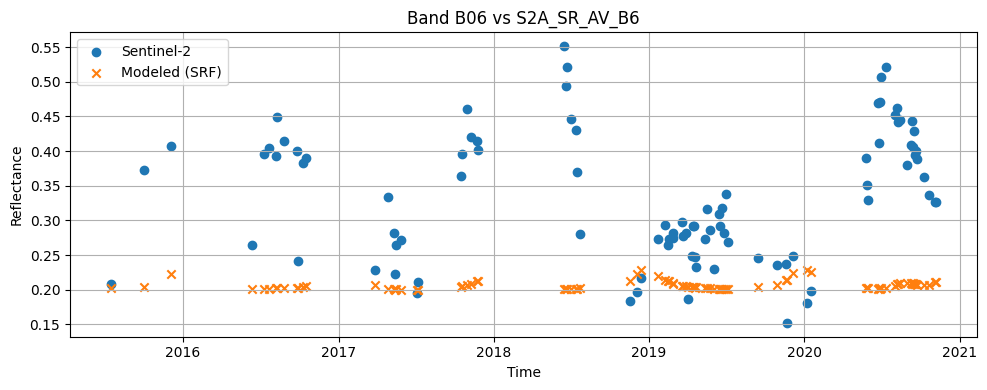

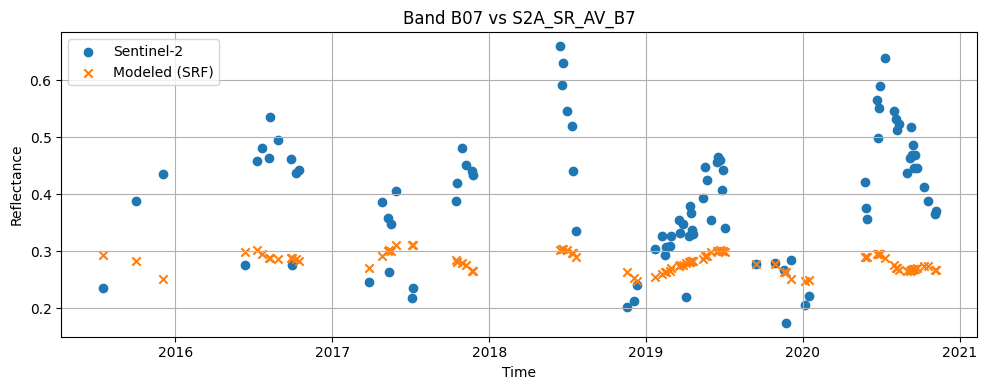

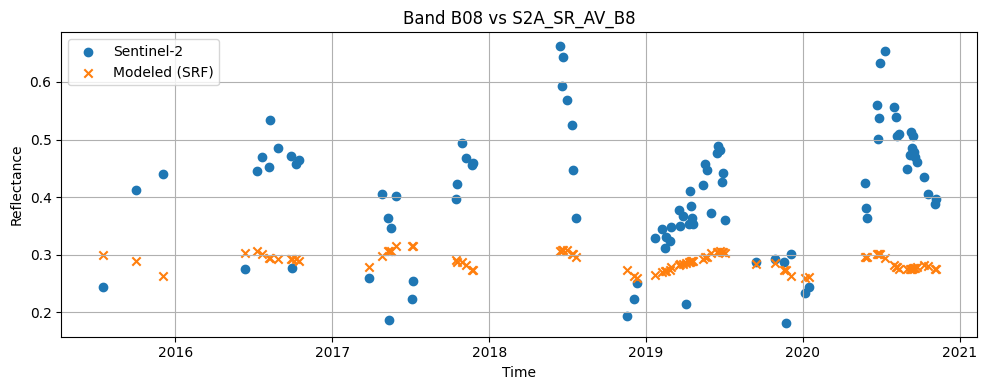

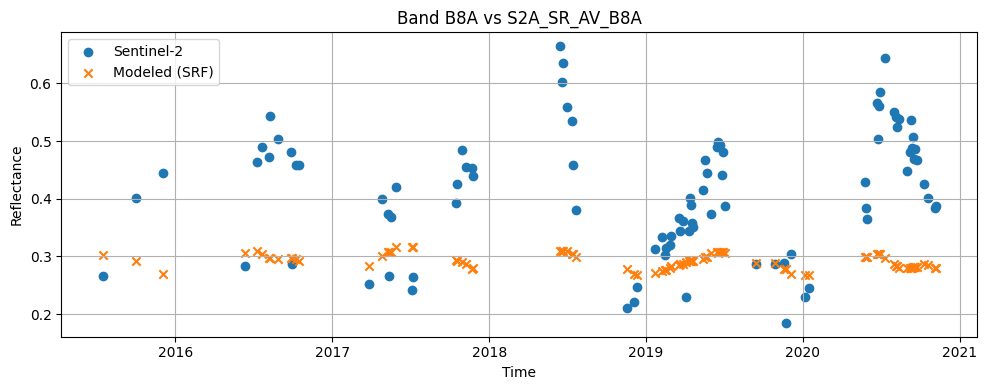

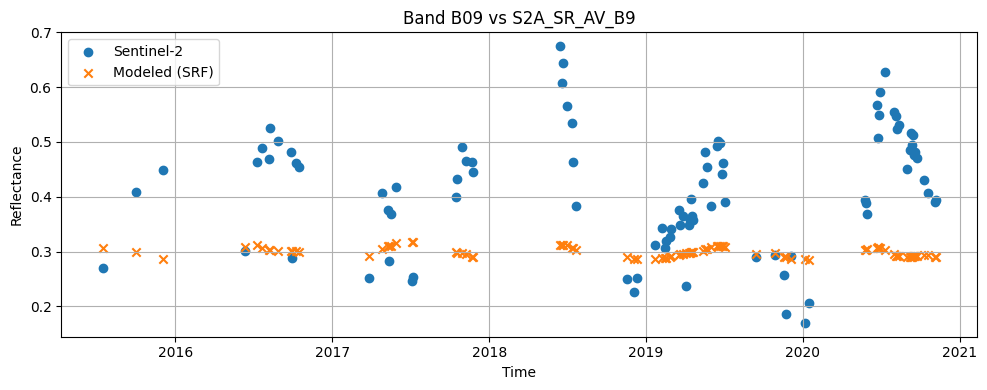

In [234]:
plot_band_comparisons(ds_sentinel2, df_band_values, band_map)


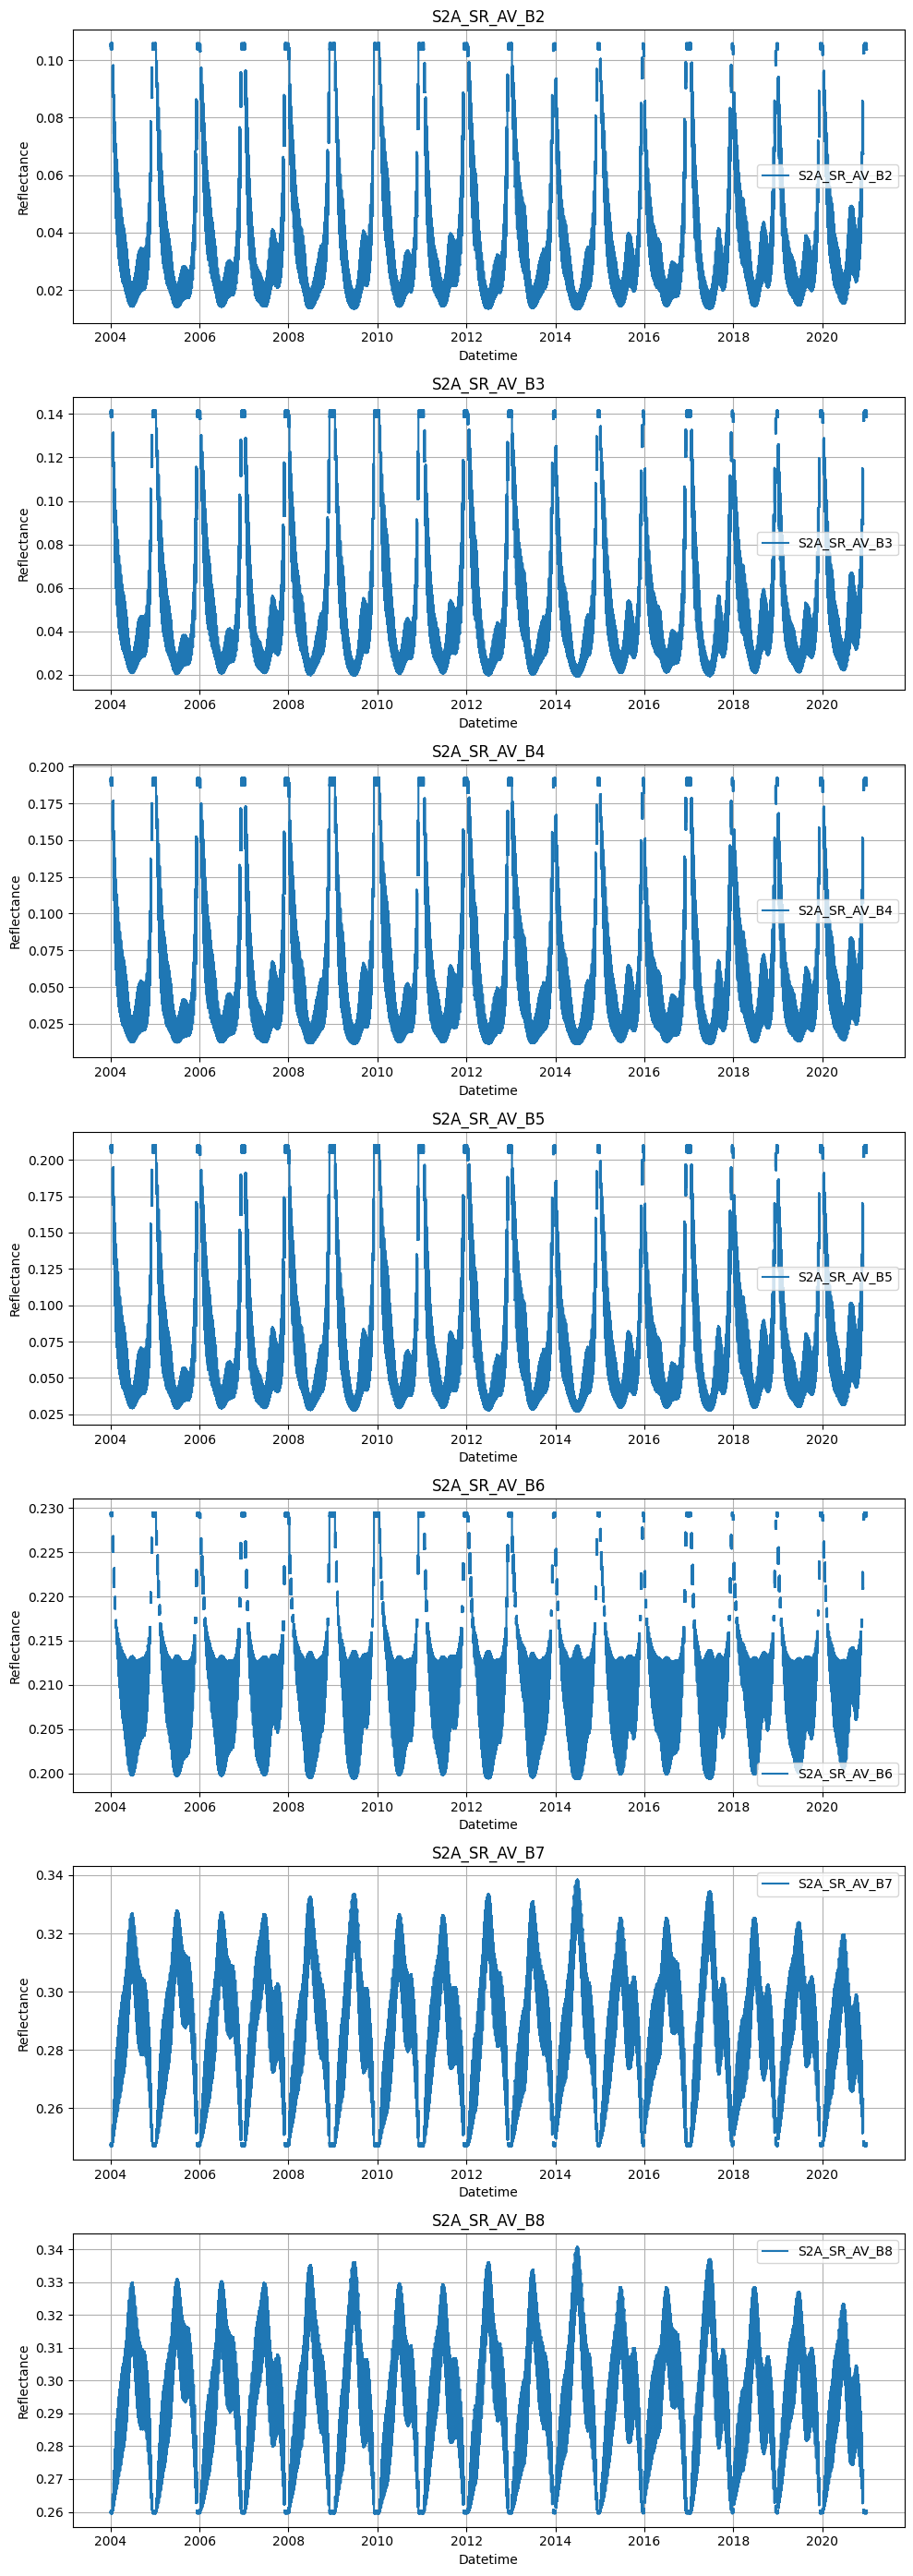

In [ ]:


def plot_bands_b2_to_b8(df_band_values_complete):
    """
    Plot the bands S2A_SR_AV_B2 to S2A_SR_AV_B8 from df_band_values_complete for the datetime range 2016-2019.
    Each band will be plotted in a separate row.
    
    Parameters:
    - df_band_values_complete (pd.DataFrame): DataFrame with datetime index and spectral band columns.
    """
    # Filter columns to include only B2 to B8
    bands_to_plot = [f'S2A_SR_AV_B{i}' for i in range(2, 9)]
    df_band_values_filtered = df_band_values_complete[bands_to_plot]

    # Filter the rows to include only data from 2016 to 2019
    # df_band_values_filtered = df_band_values_filtered.loc['2016-01-01':'2016-12-31']

    # Set the figure size based on the number of bands (6 bands in total)
    num_bands = len(df_band_values_filtered.columns)
    fig, axes = plt.subplots(num_bands, 1, figsize=(10, num_bands * 4))

    # If only one subplot, axes is not a 2D array, so handle separately
    if num_bands == 1:
        axes = [axes]

    for idx, band in enumerate(df_band_values_filtered.columns):
        ax = axes[idx]
        ax.plot(df_band_values_filtered.index, df_band_values_filtered[band], label=band)
        ax.set_title(band)
        ax.set_xlabel('Datetime')
        ax.set_ylabel('Reflectance')
        ax.grid(True)
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Call the function to plot the bands
plot_bands_b2_to_b8(df_band_values_complete)
